# Analysis: PCA to identify effort dimensions

In this notebook, we will use Principal Component Analysis (PCA) to identify the most relevant planes (components) of effort among the features in the dataset(s) we created in the previous script. We do this paralel to extreme gradient boosting (XGBoost) because unlike PCA, XGBoost does not prevent from cummulating most relevant features that are correlated, i.e., they likely explain similar dimension of effort. To increase interpretative power of our analysis, we will combine these two methods to identify the most relevant features within the most relevant dimensions (i.e., components) of effort.


In [32]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

curfolder = os.getcwd()

# This is where our features live
features = curfolder + '\\..\\07_TS_featureExtraction\\Datasets\\'
dfs = glob.glob(features + '*.csv') 

print(dfs)

['e:\\FLESH_ContinuousBodilyEffort\\08_Analysis_XGBoost\\..\\07_TS_featureExtraction\\Datasets\\features_df_final.csv', 'e:\\FLESH_ContinuousBodilyEffort\\08_Analysis_XGBoost\\..\\07_TS_featureExtraction\\Datasets\\features_df_gesture.csv', 'e:\\FLESH_ContinuousBodilyEffort\\08_Analysis_XGBoost\\..\\07_TS_featureExtraction\\Datasets\\features_df_combination.csv', 'e:\\FLESH_ContinuousBodilyEffort\\08_Analysis_XGBoost\\..\\07_TS_featureExtraction\\Datasets\\features_df_vocal.csv']


Because within the three distinct modalities - gesture, vocalization, combined - a set of different components could be decisive to characterize effort, we will perform PCA on each modality separately.

In [36]:
# This is gesture data
ges = [x for x in dfs if 'gesture' in x]
data_ges = pd.read_csv(ges[0])

# This is vocalization data
voc = [x for x in dfs if 'vocal' in x]
data_voc = pd.read_csv(voc[0])

# This is multimodal data
multi = [x for x in dfs if 'combination' in x]
data_multi = pd.read_csv(multi[0])

## PCA: Gesture

Let's start by cleaning the dataframe. In gesture modality, some of the features are not relevant to the current analysis - those are mainly the ones that are related to acoustics and concept-related information. We will remove them from the dataframe before performing PCA.

In [37]:
# Function to clean the data
def clean_df(df, colstodel):

    # Delete all desired columns
    df = df.loc[:,~df.columns.str.contains('|'.join(colstodel))]

    # Fill NaNs with 0
    df = df.fillna(0)   # FLAGGED: this we might change, maybe not the best method (alternative: MICE)

    # Leave only numerical cols, except correction_info
    df = df.select_dtypes(include=['float64','int64'])
    
    return df

In [38]:
# These are answer related columns
conceptcols = ['answer', 'expressibility', 'response']

# These are vocalization related columns
voccols = ['envelope', 'loudness', 'roughness', 'flux', 'novelty', 'harmEnergy', 'audio', 'f0', 'f1', 'f2', 'f3', 'env_', 'duration_voc']

# Concatenate both lists
colstodel = conceptcols + voccols

# Clean the df
ges_clean = clean_df(data_ges, colstodel)

ges_clean.head(15)

,arm_duration,arm_inter_Kin,arm_inter_IK,arm_bbmv,arm_bbmv_rate,lowerbody_duration,lowerbody_inter_Kin,lowerbody_inter_IK,lowerbody_bbmv,lowerbody_bbmv_rate,...,pelvis_moment_sum_change_range,pelvis_moment_sum_change_rate,body_nComp_80,body_slope_80,body_nComp_95,body_slope_95,arm_nComp_80,arm_slope_80,arm_nComp_95,arm_slope_95
0,3760.0,28.149240,30.017435,-1.859849,-0.000495,3322.0,27.440195,28.521148,-6.577333,-0.001980,...,0.105807,0.000012,5,0.129771,9,0.081558,4,0.167738,7,0.107147
1,5824.0,29.469840,30.833535,0.250250,0.000043,5946.0,29.512191,31.374474,-1.087982,-0.000183,...,0.203442,0.000010,5,0.114010,11,0.059262,4,0.164436,8,0.090760
2,4538.0,29.540275,30.614714,-2.068191,-0.000456,4308.0,28.621588,28.383534,-8.086294,-0.001877,...,0.141222,0.000013,4,0.138047,7,0.082580,3,0.184634,6,0.098621
3,4758.0,28.841040,30.474840,-2.150583,-0.000452,4242.0,28.499463,29.405677,-7.696432,-0.001814,...,0.137771,0.000010,5,0.123052,9,0.076240,4,0.146716,7,0.097021
4,4574.0,28.841029,30.475538,-2.626923,-0.000574,3822.0,28.321166,29.018108,-7.706197,-0.002016,...,0.178952,0.000011,5,0.119249,9,0.073609,4,0.175968,8,0.094311
5,5954.0,30.169922,31.804769,-1.775415,-0.000298,5762.0,30.080733,29.812870,-6.688649,-0.001161,...,0.075758,0.000005,5,0.128996,10,0.070581,5,0.124317,8,0.086842
6,2704.0,26.941429,26.879425,-5.670292,-0.002097,0.0,0.000000,0.000000,0.000000,0.000000,...,0.065336,0.000010,3,0.185979,7,0.086742,3,0.163064,6,0.094508
7,4250.0,29.455030,29.475774,-4.099438,-0.000965,0.0,0.000000,0.000000,0.000000,0.000000,...,0.099991,0.000007,3,0.108663,7,0.057857,3,0.190342,6,0.105669
8,2474.0,26.968241,28.292222,-4.872051,-0.001969,1286.0,24.928558,24.932559,-10.762294,-0.008369,...,0.197798,0.000016,4,0.147381,6,0.108030,4,0.162386,6,0.119986
9,4640.0,29.235632,30.165502,-2.576503,-0.000555,4196.0,28.619188,28.463191,-6.874801,-0.001638,...,0.133956,0.000011,4,0.152865,8,0.082598,4,0.160911,7,0.102753


### Identifying principal components

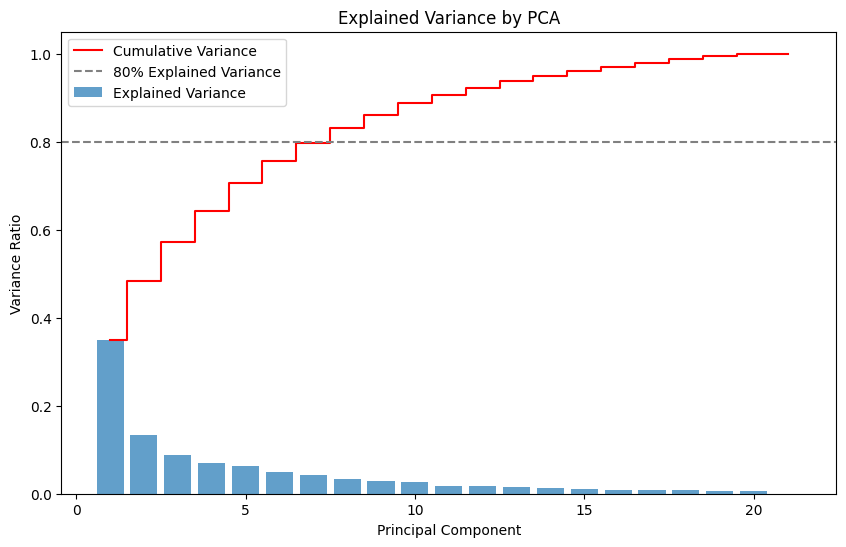

In [40]:
features = ges_clean

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(features_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Explained Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Variance', color='red')
# Make a line for 80% variance
plt.axhline(y=0.8, color='gray', linestyle='--', label='80% Explained Variance')
plt.ylabel('Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Explained Variance by PCA')
plt.legend()
plt.show()


### Identifying contributors within components

Number of components explaining 80.0% variance: 8

Feature Contributions to Principal Components:
      arm_duration  arm_inter_Kin  arm_inter_IK  arm_bbmv  arm_bbmv_rate  \
PC1       0.047663       0.045683      0.052777  0.068957       0.064175   
PC2      -0.095324      -0.089559     -0.076434  0.019976      -0.033283   
PC3       0.044504       0.030896      0.026771  0.036486       0.032445   
PC4      -0.010815      -0.020208     -0.029573 -0.010505      -0.020373   
PC5      -0.023491      -0.059933     -0.077521 -0.078263      -0.083172   
PC6       0.020553       0.023817      0.013539 -0.038127      -0.024187   
PC7       0.014488       0.063417      0.030568  0.003750       0.028149   
PC8      -0.047099      -0.034700     -0.015830  0.030542      -0.017203   
PC9      -0.031648       0.012448     -0.022460  0.018097       0.006011   
PC10      0.048062       0.036577     -0.016171  0.044922       0.058618   
PC11      0.007992      -0.003664     -0.020218  0.054035       0.

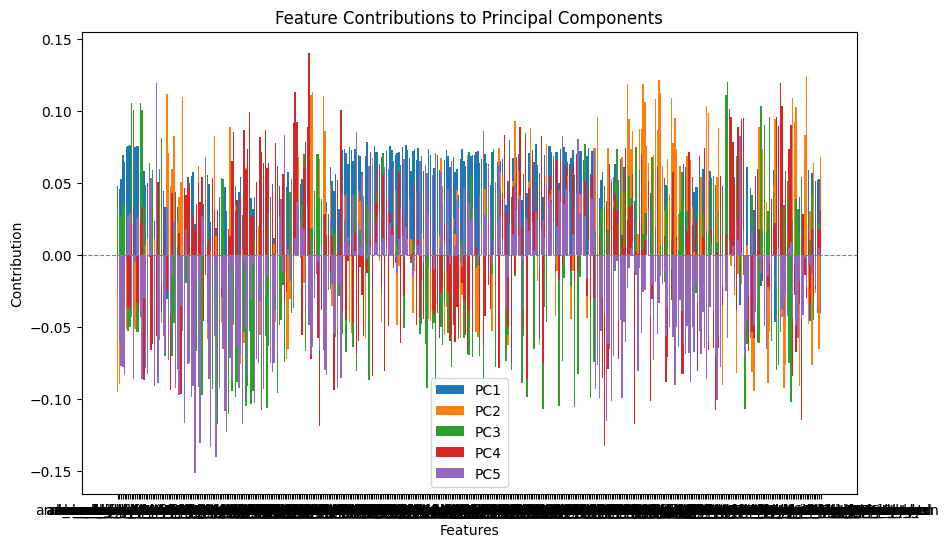

In [43]:
# Determine the number of significant components
threshold = 0.80
num_components = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components explaining {threshold*100}% variance: {num_components}")

# Feature contributions to each principal component
feature_contributions = pd.DataFrame(
    pca.components_,
    columns=features.columns,
    index=[f'PC{i+1}' for i in range(len(pca.components_))]
)

print("\nFeature Contributions to Principal Components:")
print(feature_contributions)

# Identify most contributing features for each principal component
top_contributors = feature_contributions.apply(lambda row: row.nlargest(20).index.tolist(), axis=1)
print("\nTop contributing features per component:")
print(top_contributors)

# Visualize feature contributions for the top components
plt.figure(figsize=(10, 6))
for i in range(min(5, len(feature_contributions))):  # Plot the first 3 components
    plt.bar(features.columns, feature_contributions.iloc[i], label=f'PC{i+1}')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Features')
plt.ylabel('Contribution')
plt.title('Feature Contributions to Principal Components')
plt.legend()
plt.show()

Save the top contributors as a file so that we can load it in for the XGBoost analysis. We will also save the clean data which we can use for XGBoost modeling too.

In [45]:
# We don't need all PC, let's keep only the first 5 as they are most likely to explain at least 80% of the variance
top_contributors = top_contributors.iloc[:5]

# Save top contributors
top_contributors.to_csv(curfolder + '\\datasets\\PCA_top_contributors.csv', index=False)

# Save clean data
ges_clean.to_csv(curfolder + '\\datasets\\ges_clean_df.csv', index=False)

## PCA: Vocalizations

do the same

## PCA: Combined

do the same